In [2]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

In [4]:
data = pd.read_csv('../../data/stan_data.csv')

# Feature extraction & Data splitting

In [10]:
featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['smiles'])
dataset = dc.data.NumpyDataset(features,data['class'])

In [11]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)

# t-sne

D:\anaconda\envs\PI3K\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\anaconda\envs\PI3K\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:>

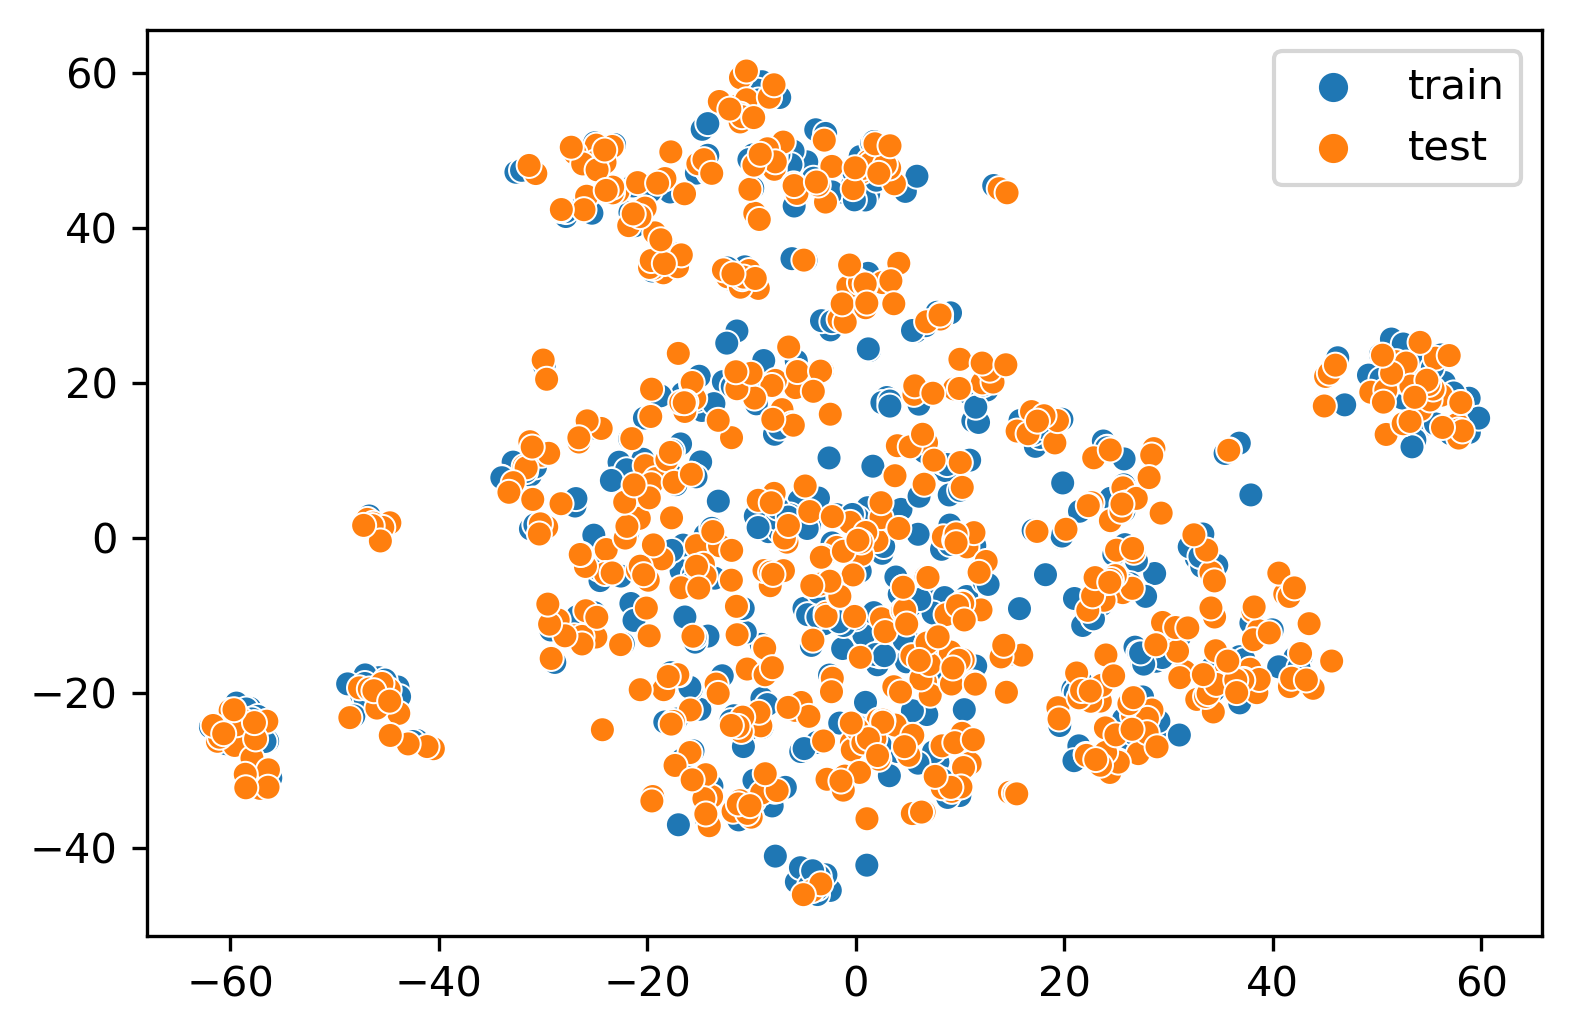

In [12]:
data_MACCSkeys = np.concatenate((train_dataset.X, test_dataset.X), axis=0)

# 运行t-SNE算法
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(data_MACCSkeys)

# 绘制结果
sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=['train']*609 + ['test']*642)

# GridSearchCV

In [13]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
            
}

classifier  =  RandomForestClassifier(random_state=42)

rf_param_grid = {'n_estimators':[50,100,150,200,250,300,350,400],
              'max_depth':[20,30,40,50,60,70,80,90,100,110],
            'max_features':["auto", "sqrt", "log2"]}
    

rf_gs = GridSearchCV(
                    classifier,
                   rf_param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=100),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

rf_gs_fit = rf_gs.fit(train_dataset.X, train_dataset.y.ravel())

In [15]:
val_AUC = rf_gs.best_score_
val_ACC = rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_]
val_PRE = rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_]
val_REC = rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_]

# GridSearchCV_Result

In [16]:
print('Best parameters: ', rf_gs.best_params_)
print('Best score (AUC): ', rf_gs.best_score_)
print('ACC: ', rf_gs.cv_results_['mean_test_ACC'][rf_gs.best_index_])
print('PRE: ', rf_gs.cv_results_['mean_test_PRE'][rf_gs.best_index_])
print('REC: ',rf_gs.cv_results_['mean_test_REC'][rf_gs.best_index_])

Best parameters:  {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Best score (AUC):  0.8727079503385952
ACC:  0.792
PRE:  0.8144679576647922
REC:  0.7483093193398466


In [17]:
rf_model = rf_gs_fit.best_estimator_
rf_model

RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=200,
                       random_state=42)

# Evaluate model

In [18]:
y_test_pred_proba = rf_model.predict_proba(test_dataset.X)
y_test_pred = rf_model.predict(test_dataset.X)

In [19]:
tn, fp, fn, tp = confusion_matrix(test_dataset.y, y_test_pred).ravel()
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

TN: 114
FP: 20
FN: 23
TP: 94


In [20]:
rf_test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    rf_test_pred_list.append(test_score)

In [21]:
rf_test_pred_array = np.array(rf_test_pred_list)

In [22]:
test_AUC = roc_auc_score(test_dataset.y,rf_test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(rf_test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(rf_test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(rf_test_pred_array))

# Finall result

In [23]:
rf_performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [24]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,AUC,ACC,PRE,REC
val,0.872708,0.792000,0.814468,0.748309
test,0.908821,0.828685,0.824561,0.803419
